# 결과

### 노드 머신러닝 실습 모델 8개 + 추천 모델 3개 추가

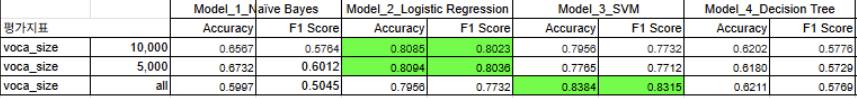

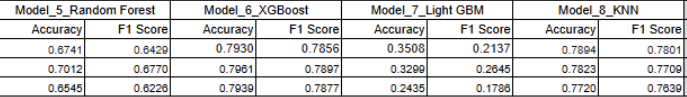

### 추천 머신 러닝 8개

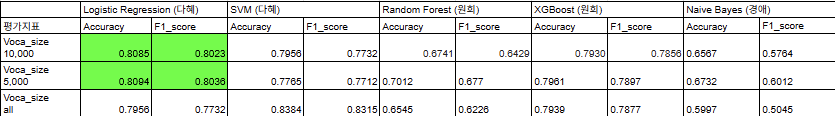

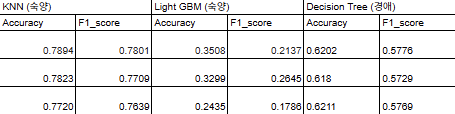

### 딥러닝

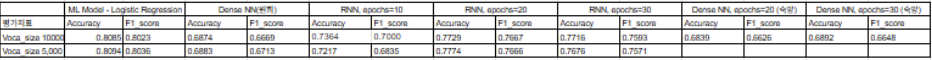

머신러닝 1등 성능 모델:  
LogisticRegression, voca_Size: 10000  
XGBoost, voca_size: 5000, INF   
딥러닝 1등 성능 모델: RNN 

TF-IDF는 주로 단어의 빈도와 중요도를 기반 -> 전통적인 머신러닝 모델(XGBoost, SVM, 로지스틱 회귀 등)과 잘 작동  
Word2Vec는 단어의 의미적, 문맥적 관계를 저차원 벡터로 표현 -> 주로 딥러닝 모델(RNN, Dense NN 등)과 결합될 때 가장 강력한 성능을 발휘

# 데이터셋 만들기

In [90]:
!pip install gensim

In [91]:
from tensorflow.keras.datasets import reuters
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# 데이터 준비
- index -> text
- DTM , TF-idf 학습데이터 준비
- W2V 학습데이터 준비

In [92]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=10000, test_split=0.2) #10000 -> 5000 -> inf

In [93]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [94]:
index_to_word = { index+3 : word for word, index in word_index.items() }
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [95]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [96]:
decoded_test = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded_test.append(t)

x_test = decoded_test
print(len(x_test))

2246


In [97]:
# 벡터화 DTM, TF-idf 방법
dtmvector = CountVectorizer()

tfidf_transformer = TfidfTransformer()

x_train_dtm = dtmvector.fit_transform(x_train)
x_test_dtm= dtmvector.transform(x_test)

x_train_tfidf = tfidf_transformer.fit_transform(x_train_dtm)
x_test_tfidf = tfidf_transformer.transform(x_test_dtm)

In [98]:
x_train[3]

"<sos> the farmers home administration the u s agriculture department's farm lending arm could lose about seven billion dlrs in outstanding principal on its severely <unk> borrowers or about one fourth of its farm loan portfolio the general accounting office gao said in remarks prepared for delivery to the senate agriculture committee brian crowley senior associate director of gao also said that a preliminary analysis of proposed changes in <unk> financial eligibility standards indicated as many as one half of <unk> borrowers who received new loans from the agency in 1986 would be <unk> under the proposed system the agency has proposed evaluating <unk> credit using a variety of financial ratios instead of relying solely on <unk> ability senate agriculture committee chairman patrick leahy d vt <unk> the proposed eligibility changes telling <unk> administrator <unk> clark at a hearing that they would mark a dramatic shift in the agency's purpose away from being farmers' lender of last re

In [99]:
# 벡터화 W2V방법
from gensim.models import Word2Vec

# 우선 문장을 토큰화 -> 띄어쓰기 기반 -> # 위에서 DTM만들때는 왜 안해줬냐! -> CountVectorizer에서 띄어쓰기 기반 토큰화가 내장되있음
x_train_tokenized = [sentence.split() for sentence in x_train]
x_test_tokenized = [sentence.split() for sentence in x_test]

model = Word2Vec(sentences = x_train_tokenized, vector_size = 256, window = 5, min_count = 5, workers = 4, sg = 0)
print("모델 학습 완료!")

모델 학습 완료!


In [100]:
model_result = model.wv.most_similar('man')
print(model_result)

[('glenn', 0.8617676496505737), ('don', 0.8569511771202087), ('iowa', 0.851399302482605), ('pechiney', 0.8507195711135864), ('debartolo', 0.8479317426681519), ('diagnostic', 0.8455610871315002), ('sydney', 0.8451241850852966), ('businessman', 0.8397796154022217), ('rica', 0.8389025926589966), ('stangeland', 0.8368949890136719)]


In [101]:
# 학습된 Word2Vec 모델
w2v_model = model

# 각 문장을 벡터화 시키는 코드
def vectorize_sentence(sentence, model, max_len):
    vecs = []
    for word in sentence:
        if word in model.wv:
            vecs.append(model.wv[word])
        else:
            vecs.append(np.zeros(model.vector_size))
    # Padding
    if len(vecs) < max_len:
        vecs += [np.zeros(model.vector_size)] * (max_len - len(vecs))
    else:
        vecs = vecs[:max_len]
    return np.array(vecs)

x_train_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_train_tokenized])
x_test_w2v = np.array([vectorize_sentence(s, w2v_model, max_len=100) for s in x_test_tokenized])




In [102]:
x_train_w2v.shape

(8982, 100, 256)

In [103]:
x_test_w2v.shape

(2246, 100, 256)

# 모델 정의 및 실험

## 다양한 머신러닝

In [104]:
# 랜덤포레스트
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators=5, random_state=0)
forest.fit(x_train_tfidf, y_train)

RandomForestClassifier(n_estimators=5, random_state=0)

In [105]:
# 예측
y_pred = forest.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.6741
✅ F1-score : 0.6429


In [106]:
# XGBoost

from xgboost import XGBClassifier

# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [107]:
# 예측
y_pred = xgb_model.predict(x_test_tfidf)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7930
✅ F1-score : 0.7856


In [108]:
# 데이터를 단어단위에서 문장단위로 바꿔줘야 한다. ML은 2차원데이터만 받을 수 있기 때문
# 문장에 대해서 토큰들의 벡터를 평균을 취해준다.

# Word2Vec 임베딩 시퀀스: (8982, 100, 256)
x_w2v_seq_train = x_train_w2v
x_w2v_seq_test = x_test_w2v
# 평균 풀링 → (8982, 256)
x_w2v_avg_train = np.mean(x_w2v_seq_train, axis=1)
x_w2v_avg_test = np.mean(x_w2v_seq_test, axis=1)
print(x_w2v_avg_train.shape)  # (8982, 256)

(8982, 256)


In [109]:
# Word2Vec 데이터로 XGBoost 모델 학습하기
from xgboost import XGBClassifier


# XGBoost 모델 학습
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, eval_metric='mlogloss')
xgb_model.fit(x_w2v_avg_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [110]:
# 예측
y_pred = xgb_model.predict(x_w2v_avg_test)

# 평가 지표
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy : {acc:.4f}")
print(f"✅ F1-score : {f1:.4f}")

✅ Accuracy : 0.7262
✅ F1-score : 0.7098


# Dense NN 딥러닝 모델

In [111]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, Dense, Dropout


dense_model = Sequential([
    Flatten(input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax') 
])

dense_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
dense_model.summary()

C:\Users\juwonhee\Anaconda3\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │      13,107,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 46)                  │           5,934 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,179,310 (50.28 MB)

 Trainable params: 13,179,310 (50.28 MB)

 Non-trainable params: 0 (0.00 B)

In [112]:
dense_model.fit(x_train_w2v, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 66s 246ms/step - accuracy: 0.5262 - loss: 2.1887 - val_accuracy: 0.6477 - val_loss: 1.5278
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step - accuracy: 0.6797 - loss: 1.3539 - val_accuracy: 0.6867 - val_loss: 1.3943
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 56s 247ms/step - accuracy: 0.7232 - loss: 1.1125 - val_accuracy: 0.6845 - val_loss: 1.3907
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 54s 239ms/step - accuracy: 0.7772 - loss: 0.8908 - val_accuracy: 0.6884 - val_loss: 1.4368
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 62s 274ms/step - accuracy: 0.8085 - loss: 0.7337 - val_accuracy: 0.6889 - val_loss: 1.5125
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 54s 240ms/step - accuracy: 0.8357 - loss: 0.6673 - val_accuracy: 0.6850 - val_loss: 1.5321
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 81s 234ms/step - accuracy: 0.8437 - loss: 0.5852 - val_accuracy: 0.6900 - val_loss: 1.5599
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 55s 244ms/step - accuracy: 0.8693 - loss: 0

In [113]:
y_pred_proba = dense_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step
✅ Accuracy: 0.6808
✅ F1-score: 0.6528


# RNN 딥러닝 모델

In [114]:
# rnn 시계열 특징 데이터 특화 모델

rnn_model = Sequential([
    LSTM(128, input_shape=(100, 256)),  # (seq_len, embedding_dim)
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(46, activation='softmax')  
])

rnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
rnn_model.summary()

C:\Users\juwonhee\Anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 128)                 │         197,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 46)                  │           2,990 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 208,366 (813.93 KB)

 Trainable params: 208,366 (813.93 KB)

 Non-trainable params: 0 (0.00 B)

In [115]:
rnn_model.fit(x_train_w2v, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - accuracy: 0.4082 - loss: 2.6061 - val_accuracy: 0.4841 - val_loss: 2.1288
Epoch 2/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 98ms/step - accuracy: 0.5245 - loss: 1.9245 - val_accuracy: 0.6233 - val_loss: 1.5658
Epoch 3/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 22s 99ms/step - accuracy: 0.6178 - loss: 1.6075 - val_accuracy: 0.6861 - val_loss: 1.3819
Epoch 4/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 21s 91ms/step - accuracy: 0.6811 - loss: 1.3787 - val_accuracy: 0.7051 - val_loss: 1.2717
Epoch 5/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 24s 104ms/step - accuracy: 0.6797 - loss: 1.3375 - val_accuracy: 0.7012 - val_loss: 1.2733
Epoch 6/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 85ms/step - accuracy: 0.7054 - loss: 1.2288 - val_accuracy: 0.7295 - val_loss: 1.1671
Epoch 7/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 19s 82ms/step - accuracy: 0.7075 - loss: 1.1640 - val_accuracy: 0.7346 - val_loss: 1.1204
Epoch 8/20
225/225 ━━━━━━━━━━━━━━━━━━━━ 25s 112ms/step - accuracy: 0.7313 - loss: 1.0832

In [116]:
y_pred_proba = rnn_model.predict(x_test_w2v)
y_pred = np.argmax(y_pred_proba, axis=1)

acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {acc:.4f}")
print(f"✅ F1-score: {f1:.4f}")

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step
✅ Accuracy: 0.7587
✅ F1-score: 0.7385


In [117]:
# voca_size = 5000
# epochs=10 일 때,
#✅ Accuracy: 0.7217
#✅ F1-score: 0.6835

# epochs=20 일 때,
#✅ Accuracy: 0.7774
#✅ F1-score: 0.7666

# epochs=30 일 때,
#✅ Accuracy: 0.7676
#✅ F1-score: 0.7571


# voca_size = 10000
# epochs=20 일 때,
#✅ Accuracy: 0.7614
#✅ F1-score: 0.7430